In [2]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import cmath as c

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# README

## Functions:
#### run_model
- input: adjacency matrix, coupling constant, time
- output: time series for all nodes

#### state_course
- input: POModel
- output: displays sin of phases

#### R_course
- input: states
- output: displays synchrony over time

#### disp_course
- input: adjacency matrix, coupling constant, time
- output: displays synchrony over time

#### R_sweep
- input: adjacency matrix, starting coupling constant, ending coupling constant, number of K values to test
- output: displays average R for given K

#### edge_R_sweep
- input: adjacency matrix, starting coupling constant, ending coupling constant, number of K values to test
- output: displays difference in phases for given K for all edges

#### gen_models
- input: none
- output: results for all possible models

#### spectrum
- input: signal
- output: spectrogram of signal

## Data:

#### POModel:
- Phase Oscillator Model
- self.G: Graph
- self.states: memory of phases
- self.w: init intrinsic freq.
- self.t: time
- self.K: coupling constant
- self.dt: time step

# NOTES
- decide on acceptable noise parameter, variance for frequencies
- decide on acceptable medium/high synchrony values: based on R_course
- generate models

In [3]:
class POModel:
    def __init__(self, A, K = 10, dt = .01):
        self.G = nx.from_numpy_matrix(A) #Graph
        self.states = np.matrix([4,1,3,5,6,2]).T #np.matrix(np.random.uniform(0,2*np.pi,size=(6,1)))# memory of phases
        self.w = np.matrix([3.0,3.3,3.6,3.9,4.2,4.5]).T#np.matrix(np.random.normal(3,.2,size=(6,1))) #init intrinsic freq.
        self.t = 0 #time
        self.K = K #coupling constant
        self.dt = dt #time step
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True, weight = 'weight')).todense() #incidence
        N = np.random.normal(0, 10, [len(D[0]), 1])
        return self.w - self.K / len(self.G) * D * np.sin(D.T * self.states[:,-1]) # + N
    
    # 4th order Runge-Kutta approximation
    def step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
        '''
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))  
        '''

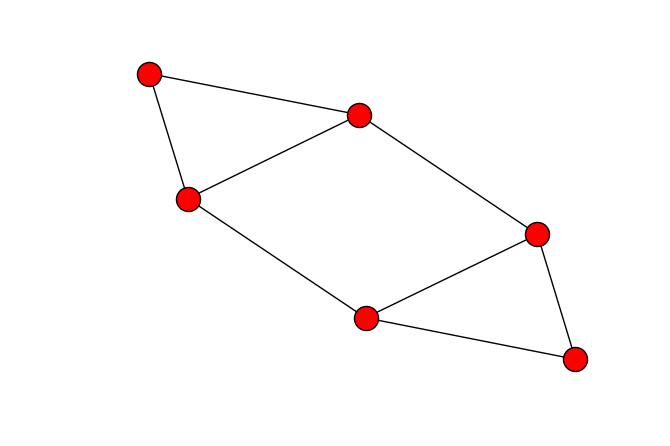

In [8]:
nodes = [1,2,3,4,5,6]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([(1,2,1),(2,3,1),(1,6,1),(1,3,1),(3,4,1),(4,5,1),(4,6,1),(5,6,1)])


#Quick plot of G
nx.draw(G)
A = nx.to_numpy_matrix(G)

In [5]:
def run_model(A, K = 10, t = 10):
    P = POModel(A, K)
    for ts in range(0,int(t/P.dt)):
        P.step()
    return P

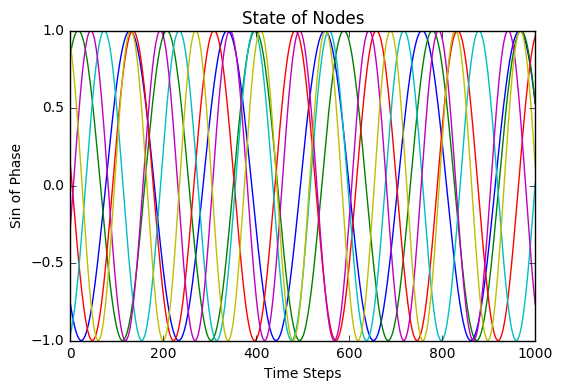

In [6]:
def state_course(states):
    plt.figure()
    plt.plot(np.sin(states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.show()
state_course(run_model(A).states)

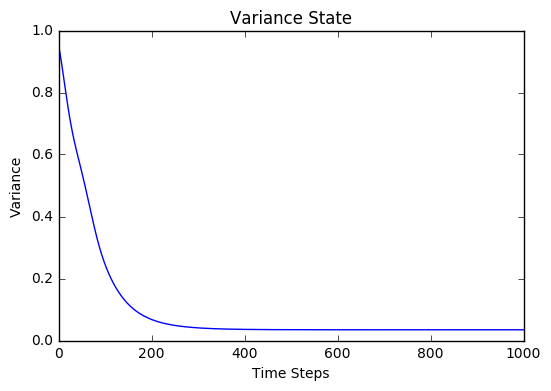

In [9]:
def R_course(states):
    Var = []
    for x in np.array(states.T):
        z = [c.exp(complex(0,phase)) for phase in x]
        z = sum(z)/len(z)
        Var.append(1-abs(z))
    plt.figure()
    plt.plot(Var)
    plt.xlabel('Time Steps')
    plt.ylabel('Variance')
    plt.title('Variance State')
    plt.show()
R_course(run_model(A).states)


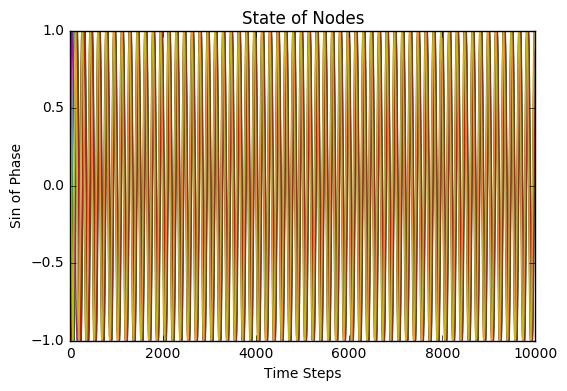

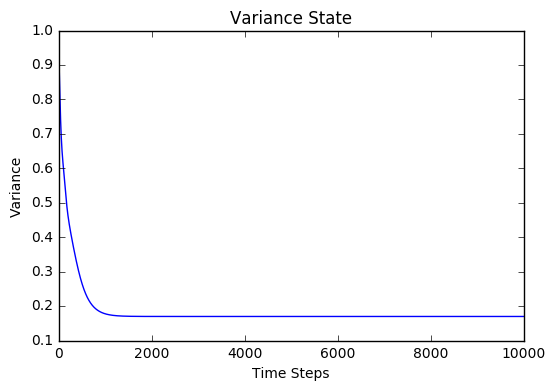

In [18]:
def disp_course(A, K = 5, t = 100):
    P = run_model(A, K, t)
    state_course(P.states)
    R_course(P.states)
disp_course(A)
    

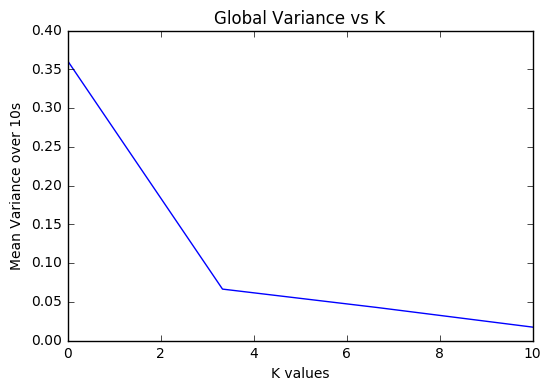

In [10]:
def R_sweep(A, Ki = 0, Kf = 10, N = 10):
    def calcR(P):
        Var = []
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            z = sum(z)/len(z)
            Var.append(1-abs(z))
        return sum(Var[round(len(Var)/2):-1])/len(Var)
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calcR(P))
    plt.figure()
    plt.plot(KSpan,KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over 10s')
    plt.title('Global Variance vs K')
    plt.show()
    return (KSpan, KVar)
KVal = R_sweep(A)

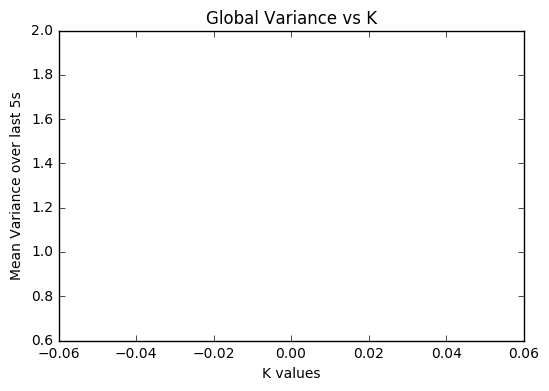

In [11]:
def edge_R_sweep(A, Ki = 0, Kf = 10, N = 10):
    def calc_edgeR(P):
        Var = []
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            edgeR = [abs(z[a] - z[b]) for (a,b) in P.G.edges()]
            Var.append(edgeR)
        Var = Var[round(len(Var)/2):-1]
        return [ sum(x)/len(Var) for x in zip(*Var)]
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calc_edgeR(P))
    plt.figure()
    plt.plot(KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over last 5s')
    plt.title('Edge Variance vs K')
    plt.show()
    return (KSpan, KVar)
KVal = edge_R_sweep(A)

In [12]:
def gen_models(A, time = 1):
    list_models = []
    list_models.append((A,run_model(A,time).states))
    SyncK = 10
    for i in range(6):
        for j in range(i):
            if A[i,j] != 0:
                G = nx.from_numpy_matrix(A)
                G[i][j]['weight'] = 0
                G[j][i]['weight'] = 0
                B = nx.to_numpy_matrix(G)
                list_models.append((B,run_model(B,time).states))
                G[i][j]['weight'] = SyncK
                G[j][i]['weight'] = SyncK
                B = nx.to_numpy_matrix(G)
                list_models.append((B,run_model(B,time).states))
    return list_models
M = gen_models(A)

129 4 129


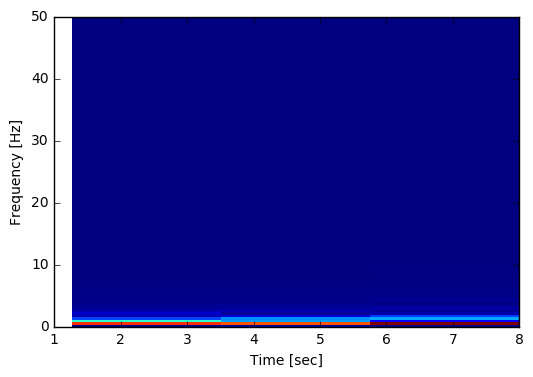

In [40]:
def spectrum(sig, fs):
    f , t , Sxx = sig.spectrogram(sig, fs, mode = 'psd')
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
course_spectrum(p[0][1][0].tolist()[0] , 100)

In [46]:
def for_each_in_model(M , f):
    for state in M:
        f(state[1])
        print(state[0])
def for_each_in_states(state , f):
    for node in state:
        f(node)
def phase_2_sig(node):
    return 10*np.sin(np.array(node)[0])
def phase_2_spec(node):
    fs = 1000
    spectrum(phase_2_sig(node),fs)

<script src="https://npmcdn.com/jupyter-js-widgets@~1.2.0/dist/embed.js"></script><script type="application/vnd.jupyter-embedded-widgets">{}</script>